In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report,confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")


In [3]:
#REVENUE FORECASTING
df = pd.read_csv("all_sales.csv .csv")
print(df.columns)



Index(['OrderDate', 'StockDate', 'OrderNumber', 'ProductKey', 'CustomerKey',
       'TerritoryKey', 'OrderLineItem', 'OrderQuantity'],
      dtype='object')


In [4]:
sales = pd.read_csv("all_sales.csv .csv")
products = pd.read_csv("Product.csv")

sales['OrderDate'] = pd.to_datetime(sales['OrderDate'])




In [5]:
print(products.columns)


Index(['ProductKey', 'ProductSubcategoryKey', 'ProductSKU', 'ProductName',
       'ModelName', 'ProductDescription', 'ProductColor', 'ProductSize',
       'ProductStyle', 'ProductCost', 'ProductPrice'],
      dtype='object')


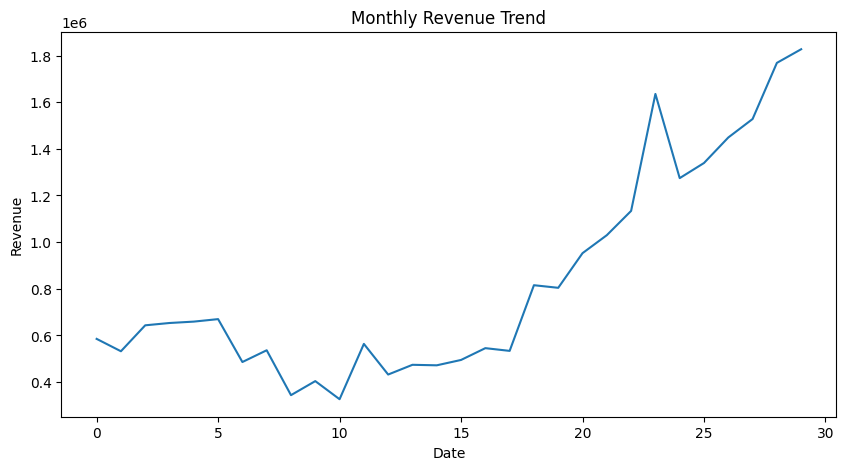

In [6]:
df = sales.merge(
    products[['ProductKey', 'ProductPrice']],
    on='ProductKey',
    how='left'
)
df['Revenue'] = df['OrderQuantity'] * df['ProductPrice']
monthly_rev = (
    df.groupby(pd.Grouper(key='OrderDate', freq='M'))['Revenue']
      .sum()
      .reset_index()
)

monthly_rev.head()
plt.figure(figsize=(10,5))
plt.plot(monthly_rev.index, monthly_rev['Revenue'])
plt.title("Monthly Revenue Trend")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

In [7]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(monthly_rev['Revenue'], order=(1,1,1))
model_fit = model.fit()

print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                   30
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -388.000
Date:                Thu, 22 Jan 2026   AIC                            782.000
Time:                        11:01:12   BIC                            786.102
Sample:                             0   HQIC                           783.285
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4955      0.974     -0.509      0.611      -2.405       1.414
ma.L1          0.2984      1.000      0.298      0.765      -1.662       2.258
sigma2      2.798e+10   6.13e-11   4.56e+20      0.0

In [8]:
# Forecast next 3 months
forecast = model_fit.forecast(steps=3)

print("Next 3 Months Revenue Forecast:")
print(forecast)


Next 3 Months Revenue Forecast:
30    1.828443e+06
31    1.827722e+06
32    1.828079e+06
Name: predicted_mean, dtype: float64


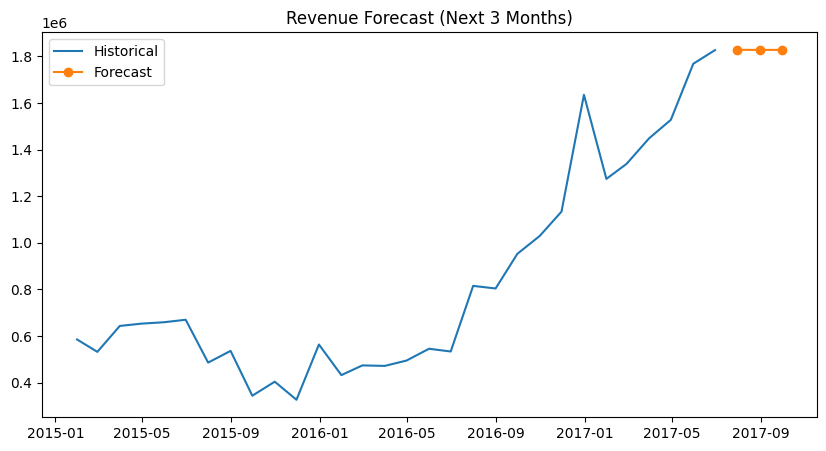

In [9]:
plt.figure(figsize=(10,5))
plt.plot(monthly_rev['OrderDate'], monthly_rev['Revenue'], label='Historical')
plt.plot(
    pd.date_range(
        start=monthly_rev['OrderDate'].iloc[-1],
        periods=4,
        freq='M'
    )[1:],
    forecast,
    label='Forecast',
    marker='o'
)
plt.legend()
plt.title("Revenue Forecast (Next 3 Months)")
plt.show()


In [10]:
#CHURN PREDICTION (CUSTOMER RETENTION)
sales = pd.read_csv("all_sales.csv .csv")
products = pd.read_csv("Product.csv")

sales['OrderDate'] = pd.to_datetime(sales['OrderDate'])

In [11]:
products.columns

Index(['ProductKey', 'ProductSubcategoryKey', 'ProductSKU', 'ProductName',
       'ModelName', 'ProductDescription', 'ProductColor', 'ProductSize',
       'ProductStyle', 'ProductCost', 'ProductPrice'],
      dtype='object')

In [12]:
df = sales.merge(
    products[['ProductKey', 'ProductPrice']],
    on='ProductKey',
    how='left'
)
df['Revenue'] = df['OrderQuantity'] * df['ProductPrice']

df[['OrderQuantity', 'ProductPrice', 'Revenue']].head()

,OrderQuantity,ProductPrice,Revenue
0,1,699.0982,699.0982
1,1,3578.2700,3578.2700
2,1,3374.9900,3374.9900
3,1,699.0982,699.0982
4,1,3578.2700,3578.2700


In [13]:
customer_features = df.groupby('CustomerKey').agg({
    'Revenue': 'sum',
    'OrderNumber': 'nunique',
    'OrderQuantity': 'sum',
    'OrderDate': 'max'
}).reset_index()

customer_features.columns = [
    'CustomerKey',
    'Total_Revenue',
    'Total_Orders',
    'Total_Quantity',
    'Last_Order_Date'
]



In [14]:
print(customer_features.columns)



Index(['CustomerKey', 'Total_Revenue', 'Total_Orders', 'Total_Quantity',
       'Last_Order_Date'],
      dtype='object')


In [15]:
max_date = df['OrderDate'].max()

customer_features['Months_Since_Last_Order'] = (
    (max_date - customer_features['Last_Order_Date']).dt.days / 30
)
customer_features['Churn'] = customer_features['Months_Since_Last_Order'].apply(
    lambda x: 1 if x > 6 else 0
)
customer_features[['CustomerKey', 'Months_Since_Last_Order', 'Churn']].head()


,CustomerKey,Months_Since_Last_Order,Churn
0,11000,7.933333,1
1,11001,0.600000,0
2,11002,10.233333,1
3,11003,7.700000,1
4,11004,8.000000,1


In [16]:
X = customer_features[
    ['Total_Revenue', 'Total_Orders', 'Total_Quantity']
]

y = customer_features['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6026794258373206
[[2910  234]
 [1842  239]]
              precision    recall  f1-score   support

           0       0.61      0.93      0.74      3144
           1       0.51      0.11      0.19      2081

    accuracy                           0.60      5225
   macro avg       0.56      0.52      0.46      5225
weighted avg       0.57      0.60      0.52      5225



In [17]:
#HIGH RETURN RISK PRODUCTS
sales = pd.read_csv("all_sales.csv .csv")
returns = pd.read_csv("Returns.csv")
products = pd.read_csv("Product.csv")
returns['Returned'] = 1


In [18]:
df_returns = sales.merge(
    returns[['ProductKey', 'Returned']],
    on='ProductKey',
    how='left'
)

df_returns['Returned'] = df_returns['Returned'].fillna(0)


In [19]:
product_features = df_returns.groupby('ProductKey').agg({
    'Returned': 'mean',          # return rate
    'OrderQuantity': 'sum',
    'OrderNumber': 'nunique'
}).reset_index()
product_features.columns = [
    'ProductKey',
    'Return_Rate',
    'Total_Quantity_Sold',
    'Total_Orders'
]



In [20]:
avg_return_rate = product_features['Return_Rate'].mean()

product_features['High_Return_Risk'] = (
    product_features['Return_Rate'] > avg_return_rate
).astype(int)
X = product_features[['Total_Quantity_Sold', 'Total_Orders']]
y = product_features['High_Return_Risk']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [21]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
high_risk_products = product_features[
    product_features['High_Return_Risk'] == 1
]

high_risk_products.sort_values(
    by='Return_Rate',
    ascending=False
).head(10)


[[ 0  7]
 [ 0 32]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.82      1.00      0.90        32

    accuracy                           0.82        39
   macro avg       0.41      0.50      0.45        39
weighted avg       0.67      0.82      0.74        39



,ProductKey,Return_Rate,Total_Quantity_Sold,Total_Orders,High_Return_Risk
0,214,1.0,73465,2099,1
88,562,1.0,438,146,1
86,560,1.0,79,79,1
85,541,1.0,18953,863,1
84,540,1.0,16695,795,1
83,539,1.0,18953,868,1
82,538,1.0,39984,957,1
81,537,1.0,35235,1305,1
80,536,1.0,27547,1059,1
79,535,1.0,35880,788,1
